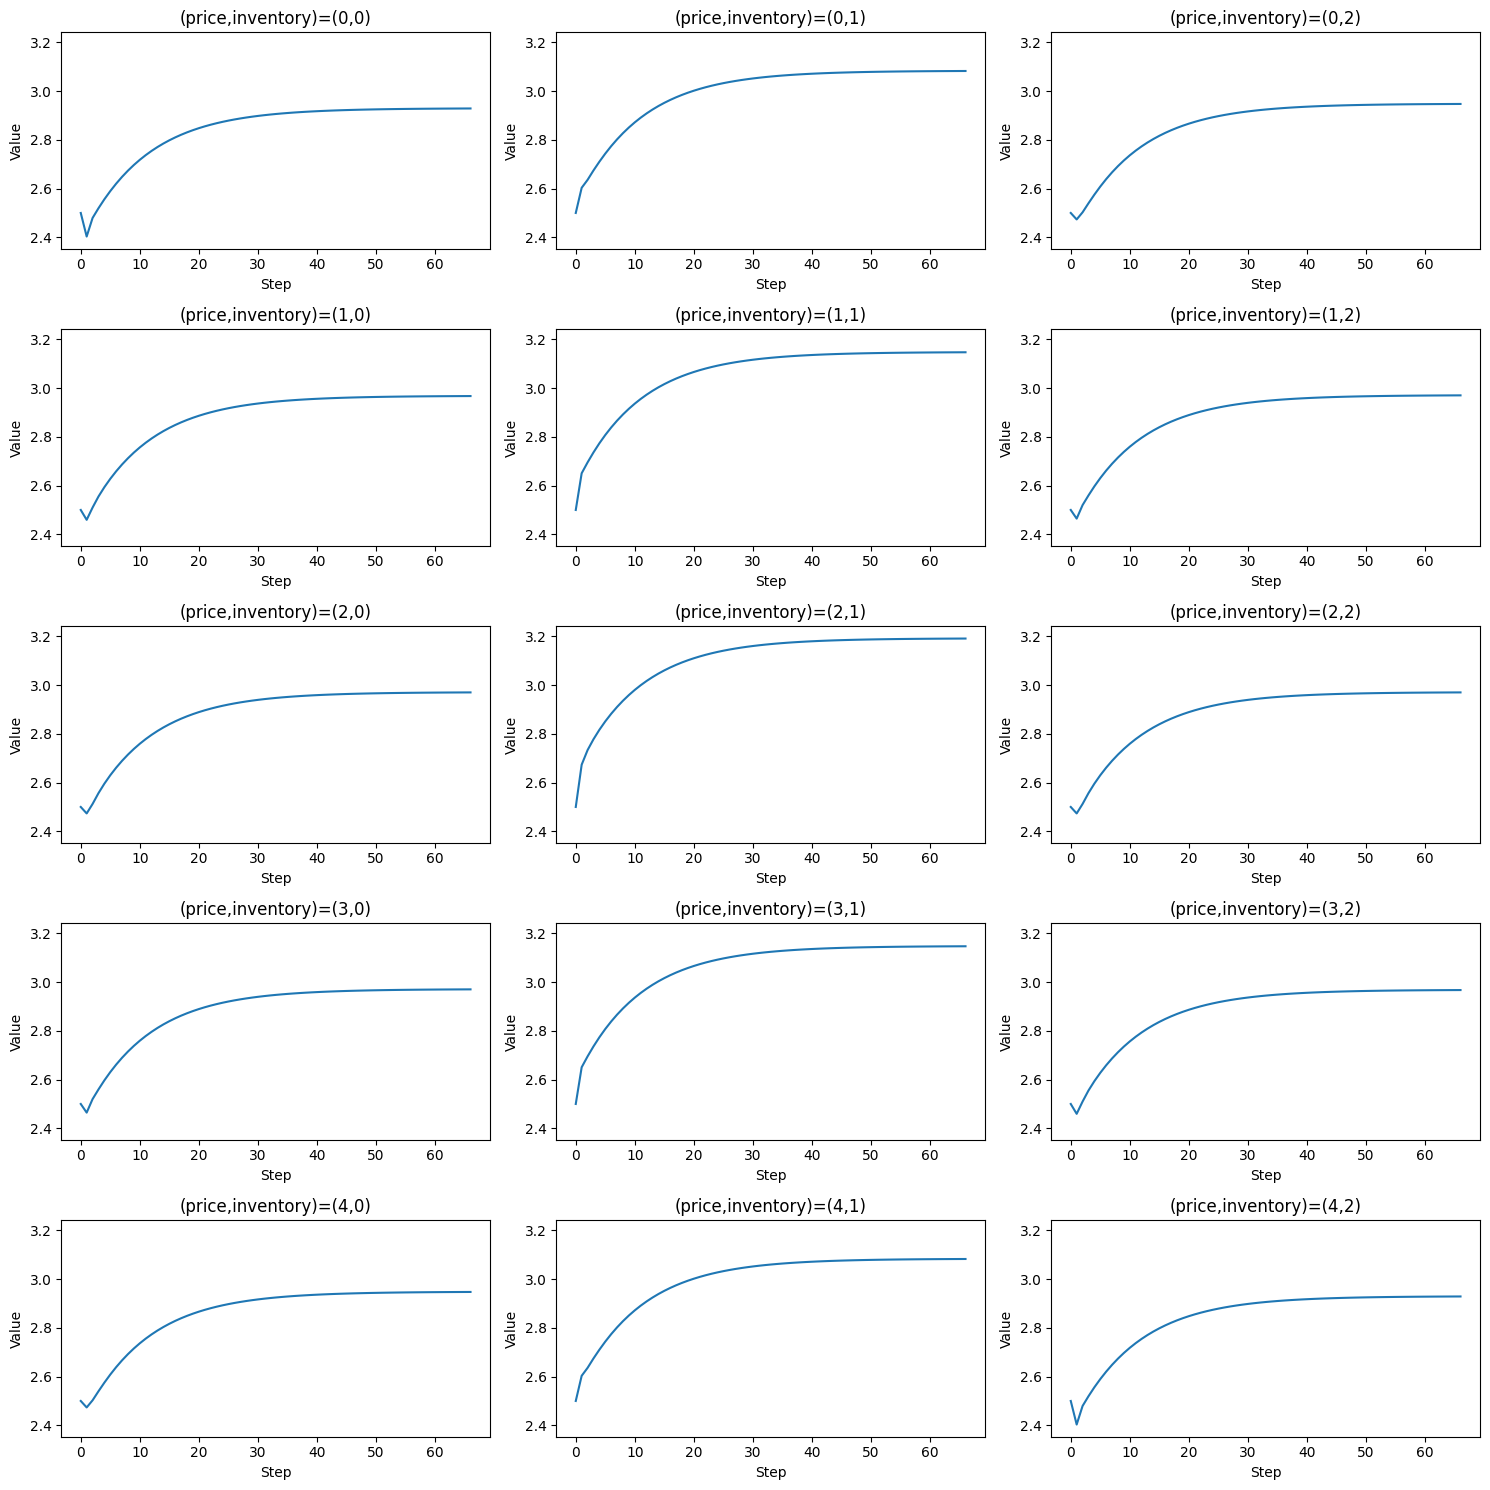

---------- true optimal value function V_star: ----------
[[2.92879062 3.0825536  2.94729361]
 [2.96738907 3.14707609 2.97024982]
 [2.97007498 3.19108224 2.97007498]
 [2.97024982 3.14707609 2.96738907]
 [2.94729361 3.0825536  2.92879062]]
---------- true optimal ask price: ----------
[[4. 2. 2.]
 [4. 3. 2.]
 [4. 3. 3.]
 [4. 3. 3.]
 [4. 3. 3.]]
---------- true optimal buy price: ----------
[[0. 0. 4.]
 [0. 0. 4.]
 [0. 0. 4.]
 [1. 0. 4.]
 [1. 1. 4.]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from q_learning_ucb import QLearningAgent
from market import MarketEnvironment

# Example usage
dim_price_grid = 3 # N_P: price grid dimension - 1 (because we start from 0)
bound_inventory = 1 # N_Y: (inventory grid dimension - 1)/2 (because we allow both - and + and 0)
dim_midprice_grid = 2*dim_price_grid-1
dim_inventory_grid = 2*bound_inventory+1
dim_action_ask_price = dim_price_grid+2
dim_action_buy_price = dim_price_grid+2
Delta = 0.1


env = MarketEnvironment(dim_price_grid, bound_inventory, dim_action_ask_price, dim_action_buy_price, Delta)
env.reset()

agent = QLearningAgent(env, dim_midprice_grid, dim_inventory_grid, dim_action_ask_price, dim_action_buy_price, Delta, 
                            UCB=False, N_RL_iter=1*10**4, N_learning_steps=1*10**4,
                        eps_epoch=0.501, exp_epoch=20,  exp=0.8, exp0=0.5, 
                        V_RL_iter_threshold = 0.065,
                        #exp=1.0, exp0=0.8, exp_epoch=100,   eps=0.8, eps0=0.95, eps_epoch=2,
                        Bellman_iter_V_initial=2.5, N_Bellman_iter = 200, Bellman_iter_threshold=1e-4)
agent.print_true_values_and_plot_Bellman_iteration()

## 2player

In [ ]:
# Example usage
dim_price_grid = 4 # N_P: price grid dimension - 1 (because we start from 0)
dim_midprice_grid = 2*dim_price_grid-1
dim_action_ask_price = dim_price_grid+2
dim_action_buy_price = dim_price_grid+2
Delta = 0.1
from market_2 import MarketEnvironment
from Nash_solver import get_action_from_nash, get_nash_value, get_policy_from_nash
env = MarketEnvironment(dim_price_grid, Delta)

solver = 'LP'
GAMMA = 0.95
GAMMA_Delta = np.exp(-GAMMA*Delta)
value_initial = 3.6

V_max_increment = float('inf')

Bellman_iter_threshold = 1e-4
N_Bellman_iter=150

V_true_converge_track_1 = np.zeros((dim_midprice_grid, N_Bellman_iter)) + value_initial
V_true_converge_track_2 = np.zeros((dim_midprice_grid, N_Bellman_iter)) + value_initial
Q_table_true_1 = dict()
Q_table_true_2 = dict()
#Q_table_true_track_1 = dict()
#Q_table_true_track_2 = dict()
for idx_midprice in range(dim_midprice_grid):
    midprice_integer = idx_midprice + 1 # midprice=midprice_integer*tick_size/2 and midprice_integer is in (1,2,...,self.dim_midprice_grid)
    action_ask_price_list = env.price_list[env.price_list>midprice_integer/2] # the action is exactly equal to the index
    action_buy_price_list = env.price_list[env.price_list<midprice_integer/2] # the action is exactly equal to the index
    dim_action = len(action_ask_price_list)*len(action_buy_price_list)
    Q_table_true_1[midprice_integer] = np.zeros((dim_action, dim_action)) + value_initial
    Q_table_true_2[midprice_integer] = np.zeros((dim_action, dim_action)) + value_initial
    #Q_table_true_track_1[midprice_integer] = np.zeros((dim_action, dim_action, N_Bellman_iter))
    #Q_table_true_track_2[midprice_integer] = np.zeros((dim_action, dim_action, N_Bellman_iter))

i = -1
while V_max_increment > Bellman_iter_threshold and i<N_Bellman_iter-2:
    i+=1
    V_true_1 = V_true_converge_track_1[:,i]
    V_true_2 = V_true_converge_track_2[:,i]
    V_max_increment = 0
    for idx_midprice in range(dim_midprice_grid):
        midprice_integer = idx_midprice + 1 # midprice=midprice_integer*tick_size/2 and midprice_integer is in (1,2,...,self.dim_midprice_grid)
        action_ask_price_list = env.price_list[env.price_list>midprice_integer/2] # the action is exactly equal to the index
        action_buy_price_list = env.price_list[env.price_list<midprice_integer/2] # the action is exactly equal to the index
        dim_action = len(action_ask_price_list)*len(action_buy_price_list)

        midprice_prob_vector = env.trans_prob_matrix_midprice[idx_midprice, :]
        for idx_optimal_1 in range(dim_action):
            for idx_optimal_2 in range(dim_action):
                idx_ask_price_1 = action_ask_price_list[idx_optimal_1//len(action_buy_price_list)]
                idx_buy_price_1 = action_buy_price_list[idx_optimal_1%len(action_buy_price_list)]
                idx_ask_price_2 = action_ask_price_list[idx_optimal_2//len(action_buy_price_list)]
                idx_buy_price_2 = action_buy_price_list[idx_optimal_2%len(action_buy_price_list)]
                prob_ask_order_filled_1, prob_ask_order_filled_2 = env.prob_executed( midprice_integer*env.tick_size/2, idx_ask_price_1*env.tick_size, idx_ask_price_2*env.tick_size, type = "ask" )
                prob_buy_order_filled_1, prob_buy_order_filled_2 = env.prob_executed( midprice_integer*env.tick_size/2, idx_buy_price_1*env.tick_size, idx_buy_price_2*env.tick_size, type = "buy" )
                reward_expected_1 = ( -midprice_integer*env.tick_size/2+idx_ask_price_1*env.tick_size )*prob_ask_order_filled_1 + ( midprice_integer*env.tick_size/2-idx_buy_price_1*env.tick_size )*prob_buy_order_filled_1 # - (inventory**2)*Delta + (midprice_next-midprice_integer)*inventory
                reward_expected_2 = ( -midprice_integer*env.tick_size/2+idx_ask_price_2*env.tick_size )*prob_ask_order_filled_2 + ( midprice_integer*env.tick_size/2-idx_buy_price_2*env.tick_size )*prob_buy_order_filled_2 # - (inventory**2)*Delta + (midprice_next-midprice_integer)*inventory
                Q_table_true_1[midprice_integer][idx_optimal_1, idx_optimal_2] = reward_expected_1 + GAMMA_Delta*np.dot(V_true_1, midprice_prob_vector)
                Q_table_true_2[midprice_integer][idx_optimal_2, idx_optimal_1] = reward_expected_2 + GAMMA_Delta*np.dot(V_true_2, midprice_prob_vector)
                # must switch idx_optimal_1 and idx_optimal_2 for player 2
        V_new_1, V_new_2 = get_nash_value(Q_table_true_1[midprice_integer], Q_table_true_2[midprice_integer], solver)
        V_true_converge_track_1[idx_midprice,i+1] = V_new_1
        V_true_converge_track_2[idx_midprice,i+1] = V_new_2
        V_max_increment = max(V_max_increment, np.max(np.abs(V_new_1-V_true_1[idx_midprice])), np.max(np.abs(V_new_2-V_true_2[idx_midprice])) )

## 1 player